In [1]:
from chainer import Link, Chain, ChainList, Variable, optimizers
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# GPU settings
gpu_index = 0
if gpu_index >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_index >= 0 else np

# 車輪型ロボットモデル（対向2輪型）

In [3]:
class Car:
    def __init__(self):
        self.pos = Variable(np.array([[0,0,0]], dtype=np.float32))
        self.path = np.zeros(3,dtype=float)

    def move(self,param):
        dx = F.reshape(param[0] * F.cos(self.pos[0][2] + param[1]), (1,1))
        dy = F.reshape(param[0] * F.sin(self.pos[0][2] + param[1]), (1,1))
        dth = F.reshape(param[1], (1,1))
        D = F.concat((dx,dy),axis=1)
        D = F.concat((D,dth),axis=1)
        
        self.pos = self.pos + D
        # set_pos
        self.path = np.vstack((self.path,np.array([self.pos.data[0][0], self.pos.data[0][1], self.pos.data[0][2]])))
        return self.pos[0][0:2]
        # 行列で演算

# 連続で動く
def calc_car_pos(car, y):
    for i in range(len(y)):
        pos = car.move(y[i])
    return pos

# 経路の描画

In [4]:
def plot_path(path,target):
    for i in range(1,len(path[:,0])):
        plt.quiver(path[i-1,0],path[i-1,1], path[i,0]-path[i-1,0],path[i,1]-path[i-1,1],scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(target[0],target[1],c="yellow",s=500,marker="*")
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.axis('scaled')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    plt.show()

variable([[ 1.          0.52359879]
          [ 1.          0.52359879]
          [ 1.          0.52359879]])


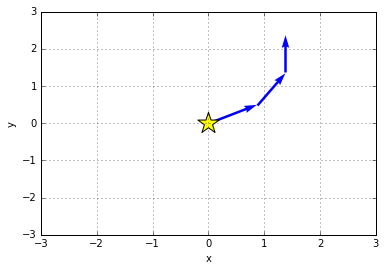

[[ 0.          0.          0.        ]
 [ 0.86602539  0.5         0.52359879]
 [ 1.36602533  1.36602545  1.04719758]
 [ 1.36602533  2.36602545  1.57079637]]


In [5]:
v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
w_arr = np.array([30.0,30.0,30.0],dtype=np.float32)
w_arr = w_arr * np.pi/180
y_data = Variable(np.vstack((v_arr,w_arr)).T )
print y_data

car = Car()
pos = calc_car_pos(car,y_data)
plot_path(car.path,[0,0])
print car.path

# ネットワーク

In [6]:
class Generator(Chain):
    def __init__(self):
        initializer = initializers.HeNormal()
        super(Generator, self).__init__(
            l1=L.Linear(2, 15, initialW=initializer),
            l2=L.Linear(15, 6, initialW=initializer),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        o = F.reshape(h2,(3,2))
        return o
    '''
    def get_vw(self,output):
        v = output[0,0:3]
        w = output[0,3:6]
        return v,w
    '''

**入出力を確認**

In [7]:
model = Generator()
x_data = np.array([[3,0]],dtype=np.float32)
x = Variable(x_data)
print x_data
y = model(x_data)
print y

[[ 3.  0.]]
variable([[ 3.6190455  -2.51612186]
          [ 0.55239755  2.84267497]
          [ 7.69672394  3.68663883]])


### 2018/10/24　オフィスアワー

---
問題点  
* **（0,0）で動かなければ損失が少ないと学習してしまう**  
    ・極座標系で距離を一定に学習する
    
    
* **optimizers.update() **  
    ・勾配を手動計算する場合は引数不要・勾配リセットも必要  
    ・そうでない場合はloss_functionを引数に渡す

その他  
* **Variable配列の型が違って気持ち悪いので行列演算にしたい**

# 極座標変換

[1, 1]
[1.4142135623730951, 45.0]


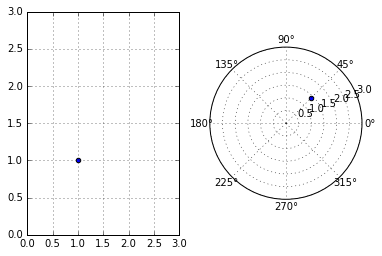

In [8]:
# 極座標変換
def to_polar_coordinate(x,y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return r,theta
# 直交座標変換
def to_cartesian_coordinate(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x,y

x,y = [1,1]
r,theta = to_polar_coordinate(x,y)
print [x,y]
print [r, theta*180/np.pi]
# 直交系グラフ
ax1 = plt.subplot(1,2,1)
ax1.scatter(x,y)
ax1.axis([0,3,0,3])
ax1.grid(True)

# 極座標系グラフ
ax2 = plt.subplot(1,2,2,polar=True)
ax2.scatter(theta,r)
ax2.set_rmax(3)
ax2.grid(True)


# 訓練データの作成

* 極座標系で角度をランダムに指定  

\begin{equation*}
\begin{bmatrix}
r = 2 \\
0 < θ < π
\end{bmatrix}
\end{equation*}

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(100, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


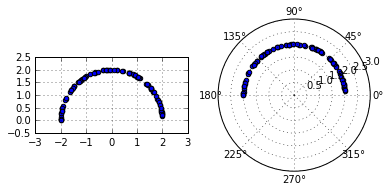

In [9]:
r = np.full(100, 2)
theta = np.random.rand(100) * np.pi
x,y = to_cartesian_coordinate(r,theta)
x_data = np.vstack((x,y))
x_data = x_data.T
#print x_data

fig1 = plt.subplot(1,2,2,polar=True)
fig1.scatter(theta,r)
fig1.set_rmax(3)
fig1.grid(True)

fig2 = plt.subplot(1,2,1)
fig2.scatter(x,y)
fig2.axis([-3,3,0,3])
plt.axis('scaled')
fig2.grid(True)

# 損失関数

In [ ]:
def calc_distance(predpos,truepos):
    tx, ty = truepos
    px, py = predpos
    D = F.sqrt(((tx-px)**2 + (ty-py)**2))
    # mean_sq　使わない
    return D

def loss_function(predpos, truepos):
    D = calc_distance(predpos, truepos)
    return D

# 訓練

In [ ]:
def train(x_data):
    model = Generator()
    opt = optimizers.Adam()
    opt.setup(model)
    iterate = 20000
    snapshot = 500
    idx = 0
    for i in range(iterate+1):
        idx = np.random.randint(len(x_data)-1)
        """
        if(idx == len(x_data)-1):
            idx = 0
        idx = idx + 1
        """
        x = Variable( np.array([x_data[idx]],dtype=np.float32) )
        y = model(x)
        truepos = Variable( np.array(x.data,dtype=np.float32) )
        car = Car()
        predpos = calc_car_pos(car,y)
        loss = loss_function(predpos,truepos[0])
        opt.update(loss_function,predpos,truepos[0])
        if (i % snapshot)==0:
            print str(i)+": loss "+str(loss.data)
            #plot_path(car.path, target_pos.data)
train(x_data)

0: loss 3.03044390678
500: loss 0.620869100094
1000: loss 0.410135418177
1500: loss 0.100180968642
2000: loss 0.0104650286958
2500: loss 0.164812192321
3000: loss 0.0320554450154
3500: loss 0.110788747668
4000: loss 0.00658976426348
4500: loss 0.0664381459355
5000: loss 0.0473433285952
5500: loss 0.0600371956825
6000: loss 0.0712841376662
6500: loss 0.0997690930963
7000: loss 0.0890682414174
7500: loss 0.0587155371904
8000: loss 0.0821083039045
8500: loss 0.0806974619627
9000: loss 0.0792253017426
9500: loss 0.0460510738194
10000: loss 0.02269477956


# 推論

In [ ]:
r = 2
theta = 10.0 * np.pi /180.0
x,y = to_cartesian_coordinate(r,theta)
x_data = Variable(np.array([[x,y]],dtype=np.float32))
o = model(x_data)
car = Car()
predict_pos = calc_car_pos(car,o)
plot_path(car.path, x_data.data[0])
target_pos = x_data[0]
loss = loss_function(target_pos, predict_pos)
print car.path
print loss

### 2018/10/30　オフィスアワー
---
* 